### Boxplots

In [1]:
import pandas as pd
import os
import glob
import re
import numpy as np
from pathlib import Path
import itertools
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import matplotlib.pyplot as plt
import numpy as np

all_rules_crm_path = os.path.join('5_analysis', 'random', 'BPI15A','combined_sorted.csv')
all_rules_crm = pd.read_csv(all_rules_crm_path, sep=',')

In [2]:
# Count unique values in 'encoding' per 'labeling'
unique_counts = (
    all_rules_crm
    .groupby("labeling")["Encoding"]
    .nunique()
    .reset_index(name="unique_encodings")
)

display(unique_counts)


,labeling,unique_encodings
0,declare,1
1,payload,9
2,sequential,1


In [3]:
# Safety check
if "Rule" not in all_rules_crm.columns:
    raise KeyError("Column 'Rule' not found in all_rules_crm.")

# Normalize to string and trim whitespace
_rule = all_rules_crm["Rule"].astype(str).str.strip()

# Fill new column based on whether the rule ends with 'Label' or '!Label'
all_rules_crm = all_rules_crm.copy()
all_rules_crm["behavior"] = np.select(
    [
        _rule.str.contains(r"-->\s*!Label\s*$", regex=True, na=False),  # ends with !Label
        _rule.str.contains(r"-->\s*Label\s*$",  regex=True, na=False),  # ends with Label
    ],
    [
        "normal",
        "deviant",
    ],
    default=pd.NA  # stays NA if neither pattern matches
)

# (Optional) quick sanity check
print(all_rules_crm["behavior"].value_counts(dropna=False))


behavior
deviant    32
normal     26
Name: count, dtype: int64


## Odds Ratio

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\3011220588.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


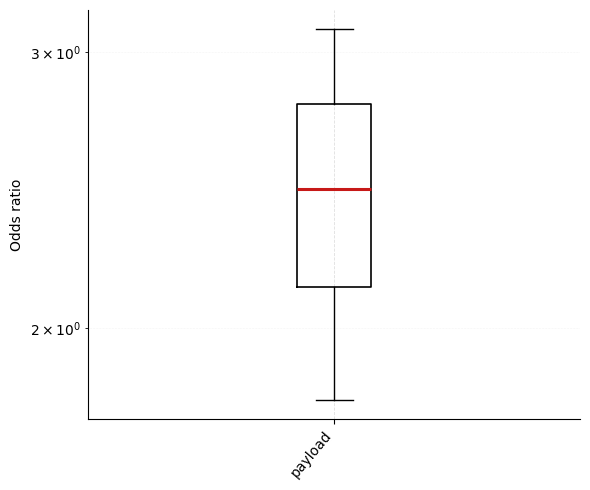

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\3011220588.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


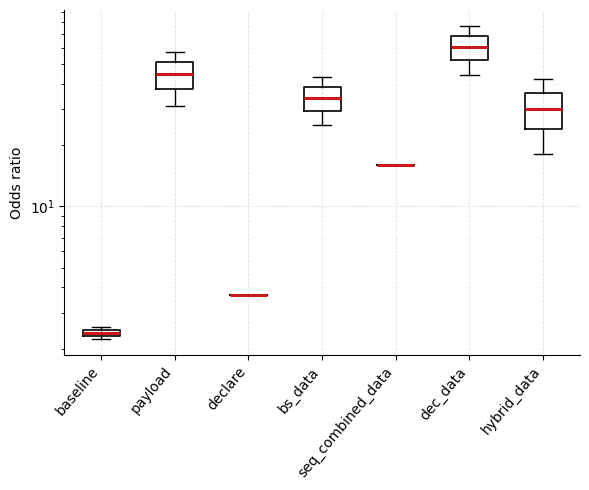

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\3011220588.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


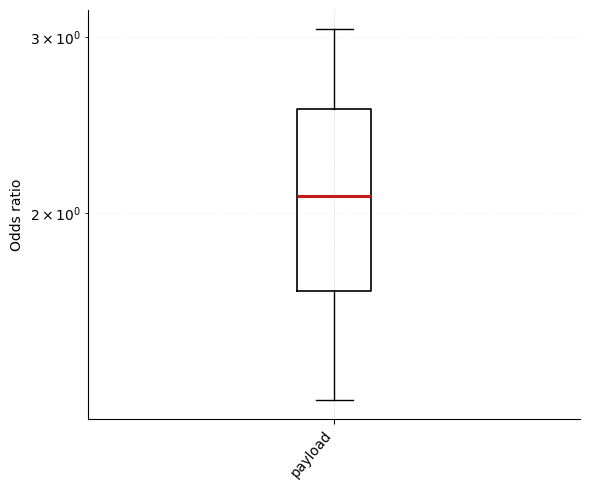

In [4]:
# ---------- 1) Locate columns (case-insensitive) ----------
def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

ENC_COL = find_col(all_rules_crm, ["Encoding", "Feature Encoding", "Feature_Encoding"])
LAB_COL = find_col(all_rules_crm, ["Labeling", "RHS_labeling"])
# Be flexible: LB OR or plain OR
OR_COL  = find_col(all_rules_crm, ["Odds Ratio", "Odds ratio"])
BEH_COL = find_col(all_rules_crm, ["behavior"])

if any(x is None for x in [ENC_COL, LAB_COL, OR_COL, BEH_COL]):
    raise ValueError(
        f"Missing required columns. Encoding={ENC_COL}, Labeling={LAB_COL}, OR={OR_COL}, Behavior={BEH_COL}"
    )

# Keep only positive numeric OR and behavior == 'deviant'
df = all_rules_crm[[LAB_COL, ENC_COL, OR_COL, BEH_COL]].copy()
df[OR_COL] = pd.to_numeric(df[OR_COL], errors="coerce")
df = df[df[OR_COL] > 0].dropna(subset=[OR_COL])

# --- NEW: filter on deviant behavior ---
df = df[df[BEH_COL].astype(str).str.strip().str.lower() == "deviant"]

# ---------- 2) Output folder & filename helper ----------
out_dir = Path("Figures")
out_dir.mkdir(parents=True, exist_ok=True)

def slugify(s: str) -> str:
    s = str(s).strip().lower().replace(" ", "_")
    return re.sub(r"[^a-z0-9_-]+", "", s)

# ---------- 3) Custom encoding order ----------
CUSTOM_ORDER = [
    "baseline", "payload", "seq_combined", "declare", "dwd",
    "bs_data", "bs_dwd", "seq_combined_data", "dec_data",
    "dec_dwd", "dec_dwd_data", "hybrid", "hybrid_data",
    "hybrid_dwd", "hybrid_dwd_data",
]
present_all = df[ENC_COL].unique().tolist()
extras = [e for e in present_all if e not in CUSTOM_ORDER]
enc_order = CUSTOM_ORDER + extras

# ---------- 4) Styling ----------
median_color = (199/255.0, 25/255.0, 24/255.0)

# ---------- 5) Plot per labeling and SAVE ----------
for labeling, dsub in df.groupby(LAB_COL):
    encs_present = [e for e in enc_order if e in dsub[ENC_COL].unique()]
    if not encs_present:
        continue

    data = [dsub.loc[dsub[ENC_COL] == e, OR_COL].values for e in encs_present]

    fig_w, fig_h = max(6, 0.6 * len(encs_present)), 5  # compact for 2-per-row in LaTeX
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    ax.boxplot(
        data,
        labels=encs_present,
        showmeans=False,
        showfliers=False,
        medianprops={"color": median_color, "linewidth": 2.2},
        boxprops={"linewidth": 1.2},
        whiskerprops={"linewidth": 1.0},
        capprops={"linewidth": 1.0},
    )

    ax.set_yscale("log")
    ax.yaxis.set_major_locator(LogLocator(base=10))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
    ax.yaxis.set_major_formatter(LogFormatterSciNotation())

    ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.4)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.25)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    # Dynamic y-label based on detected OR column
    ax.set_ylabel(OR_COL)

    plt.xticks(rotation=50, ha="right")
    plt.tight_layout()

    # Save BEFORE show
    fname_base = f"boxplot_or_{slugify(labeling)}"
    fig.savefig(out_dir / f"{fname_base}.png", dpi=300, bbox_inches="tight")
    # Optional vector version:
    # fig.savefig(out_dir / f"{fname_base}.pdf", bbox_inches="tight")

    plt.show()


## Lift

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\2017888793.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


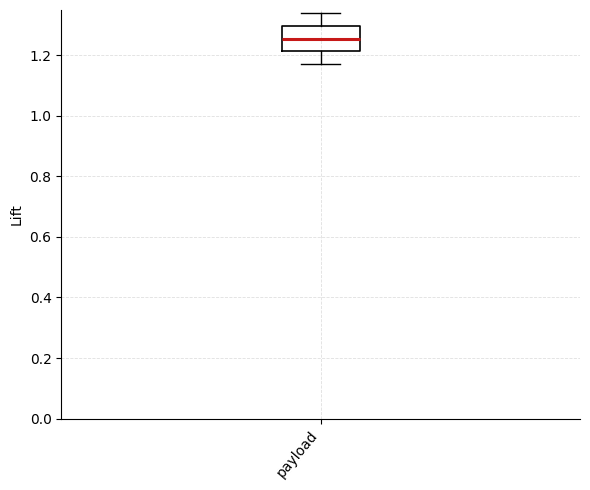

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\2017888793.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


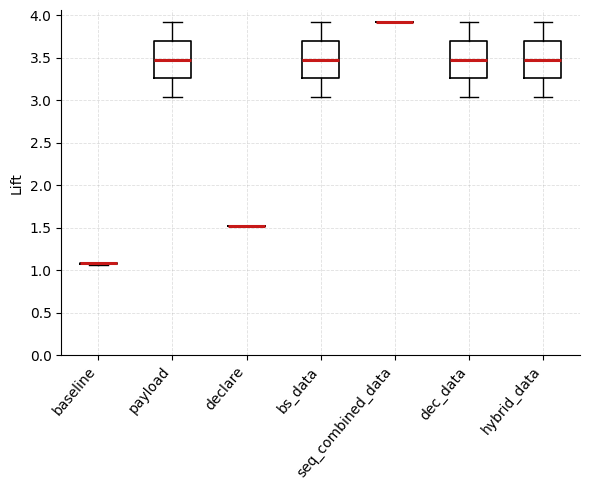

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\2017888793.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


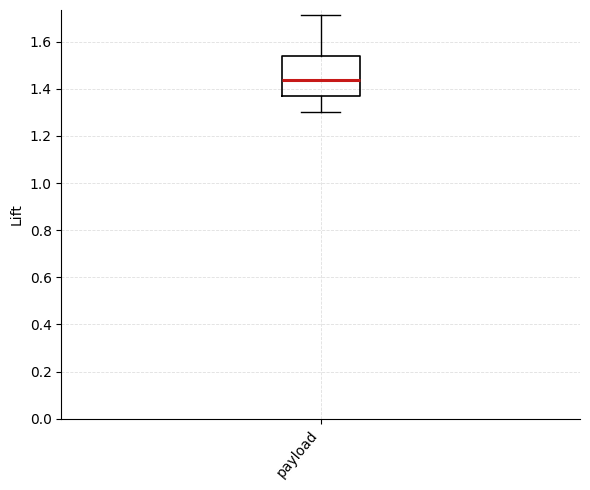

In [5]:
# ---------- 1) Locate columns (case-insensitive) ----------
def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

ENC_COL = find_col(all_rules_crm, ["Encoding", "encoding", "Feature Encoding", "Feature_Encoding"])
LAB_COL = find_col(all_rules_crm, ["Labeling", "labeling", "Label", "RHS_labeling"])
LIFT_COL = find_col(all_rules_crm, ["Lift", "lift"])
BEH_COL = find_col(all_rules_crm, ["behavior", "Behavior"])

if any(x is None for x in [ENC_COL, LAB_COL, LIFT_COL, BEH_COL]):
    raise ValueError(
        f"Missing required columns. Encoding={ENC_COL}, Labeling={LAB_COL}, Lift={LIFT_COL}, Behavior={BEH_COL}"
    )

# ---------- 2) Prepare data ----------
df = all_rules_crm[[LAB_COL, ENC_COL, LIFT_COL, BEH_COL]].copy()
# keep only deviant behavior
df = df[df[BEH_COL].astype(str).str.strip().str.lower() == "deviant"]

df[LIFT_COL] = pd.to_numeric(df[LIFT_COL], errors="coerce")
# keep sensible range (as you noted: 0..45)
df = df[(df[LIFT_COL] >= 0) & (df[LIFT_COL] <= 45)].dropna(subset=[LIFT_COL])

# ---------- 3) Output folder & filename helper ----------
out_dir = Path("Figures")
out_dir.mkdir(parents=True, exist_ok=True)

def slugify(s: str) -> str:
    s = str(s).strip().lower().replace(" ", "_")
    return re.sub(r"[^a-z0-9_-]+", "", s)

# ---------- 4) Custom encoding order ----------
CUSTOM_ORDER = [
    "baseline", "payload", "seq_combined", "declare", "dwd",
    "bs_data", "bs_dwd", "seq_combined_data", "dec_data",
    "dec_dwd", "dec_dwd_data", "hybrid", "hybrid_data",
    "hybrid_dwd", "hybrid_dwd_data",
]
present_all = df[ENC_COL].unique().tolist()
extras = [e for e in present_all if e not in CUSTOM_ORDER]
enc_order = CUSTOM_ORDER + extras

# ---------- 5) Styling ----------
median_color = (199/255.0, 25/255.0, 24/255.0)

# ---------- 6) Plot per labeling and SAVE ----------
for labeling, dsub in df.groupby(LAB_COL):
    encs_present = [e for e in enc_order if e in dsub[ENC_COL].unique()]
    data = [dsub.loc[dsub[ENC_COL] == e, LIFT_COL].values for e in encs_present]

    fig_w, fig_h = max(6, 0.6 * len(encs_present)), 5  # compact for 2-per-row
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    ax.boxplot(
        data,
        labels=encs_present,
        showmeans=False,
        showfliers=False,
        medianprops={"color": median_color, "linewidth": 2.2},
        boxprops={"linewidth": 1.2},
        whiskerprops={"linewidth": 1.0},
        capprops={"linewidth": 1.0},
    )

    # Linear scale (Lift ~ 0..45)
    ax.set_ylim(0, None)  # if you want auto upper bound, use: ax.set_ylim(0, None)

    # Clean look
    ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.4)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    ax.set_ylabel("Lift")
    plt.xticks(rotation=50, ha="right")
    plt.tight_layout()

    # Save BEFORE show
    fname_base = f"boxplot_lift_{slugify(labeling)}"
    fig.savefig(out_dir / f"{fname_base}.png", dpi=300, bbox_inches="tight")
    # Optional vector export:
    # fig.savefig(out_dir / f"{fname_base}.pdf", bbox_inches="tight")

    plt.show()


## Confidence

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\4039622036.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


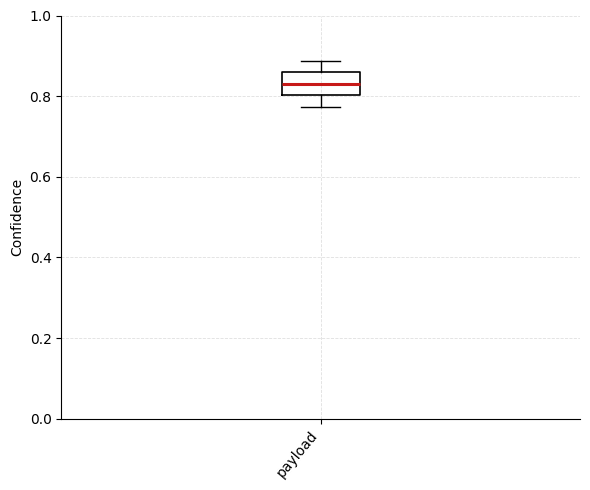

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\4039622036.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


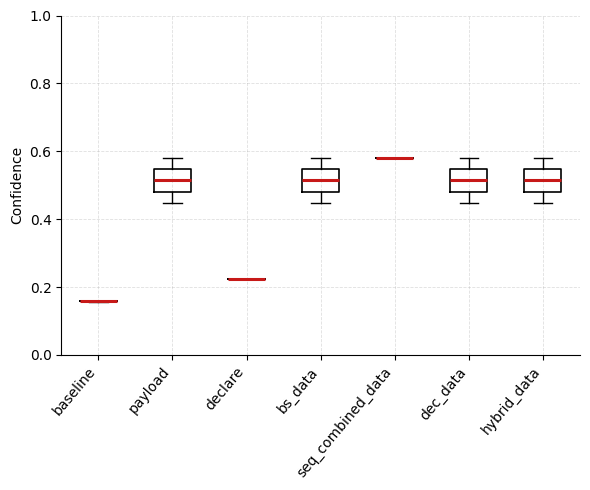

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\4039622036.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


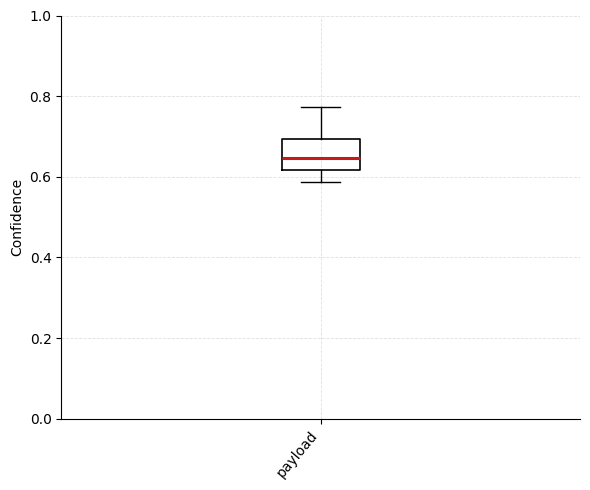

In [6]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1) Locate columns (case-insensitive) ----------
def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

ENC_COL = find_col(all_rules_crm, ["Encoding", "encoding", "Feature Encoding", "Feature_Encoding"])
LAB_COL = find_col(all_rules_crm, ["Labeling", "labeling", "Label", "RHS_labeling"])
CONF_COL = find_col(all_rules_crm, ["Confidence", "confidence", "Conf", "conf"])
BEH_COL = find_col(all_rules_crm, ["behavior", "Behavior"])

if any(x is None for x in [ENC_COL, LAB_COL, CONF_COL, BEH_COL]):
    raise ValueError(
        f"Missing required columns. Encoding={ENC_COL}, Labeling={LAB_COL}, Confidence={CONF_COL}, Behavior={BEH_COL}"
    )

# ---------- 2) Prepare data ----------
df = all_rules_crm[[LAB_COL, ENC_COL, CONF_COL, BEH_COL]].copy()

# keep only deviant behavior
df = df[df[BEH_COL].astype(str).str.strip().str.lower() == "deviant"]

df[CONF_COL] = pd.to_numeric(df[CONF_COL], errors="coerce")
df = df[(df[CONF_COL] >= 0) & (df[CONF_COL] <= 1)].dropna(subset=[CONF_COL])

# ---------- 3) Output folder & filename helper ----------
out_dir = Path("Figures")
out_dir.mkdir(parents=True, exist_ok=True)

def slugify(s: str) -> str:
    s = str(s).strip().lower().replace(" ", "_")
    return re.sub(r"[^a-z0-9_-]+", "", s)

# ---------- 4) Custom encoding order ----------
CUSTOM_ORDER = [
    "baseline", "payload", "seq_combined", "declare", "dwd",
    "bs_data", "bs_dwd", "seq_combined_data", "dec_data",
    "dec_dwd", "dec_dwd_data", "hybrid", "hybrid_data",
    "hybrid_dwd", "hybrid_dwd_data",
]
present_all = df[ENC_COL].unique().tolist()
extras = [e for e in present_all if e not in CUSTOM_ORDER]
enc_order = CUSTOM_ORDER + extras

# ---------- 5) Styling ----------
median_color = (199/255.0, 25/255.0, 24/255.0)

# ---------- 6) Plot per labeling and SAVE ----------
for labeling, dsub in df.groupby(LAB_COL):
    encs_present = [e for e in enc_order if e in dsub[ENC_COL].unique()]
    data = [dsub.loc[dsub[ENC_COL] == e, CONF_COL].values for e in encs_present]

    fig_w, fig_h = max(6, 0.6 * len(encs_present)), 5  # compact for 2-per-row
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    ax.boxplot(
        data,
        labels=encs_present,
        showmeans=False,
        showfliers=False,
        medianprops={"color": median_color, "linewidth": 2.2},
        boxprops={"linewidth": 1.2},
        whiskerprops={"linewidth": 1.0},
        capprops={"linewidth": 1.0},
    )

    # Linear 0..1 scale
    ax.set_ylim(0, 1)

    # Clean look
    ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.4)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    ax.set_ylabel("Confidence")
    plt.xticks(rotation=50, ha="right")
    plt.tight_layout()

    # Save BEFORE show
    fname_base = f"boxplot_confidence_{slugify(labeling)}"
    fig.savefig(out_dir / f"{fname_base}.png", dpi=300, bbox_inches="tight")
    # Optional vector export:
    # fig.savefig(out_dir / f"{fname_base}.pdf", bbox_inches="tight")

    plt.show()


## Conviction

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\1207973601.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


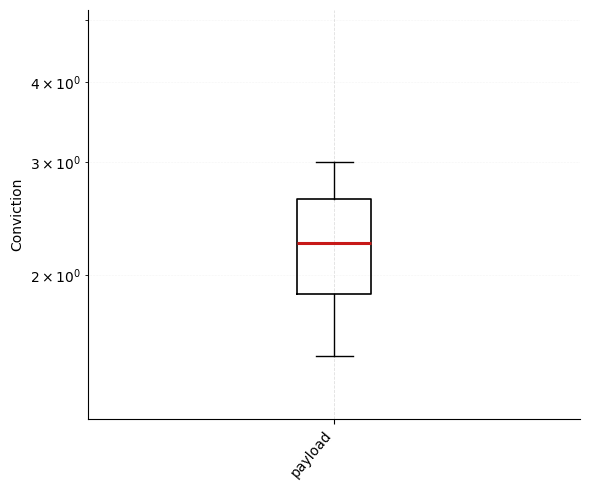

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\1207973601.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


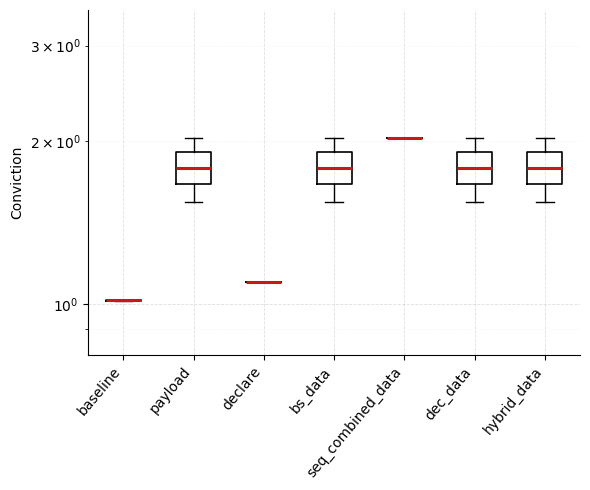

C:\Users\RowanGriffioen\AppData\Local\Temp\ipykernel_14320\1207973601.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


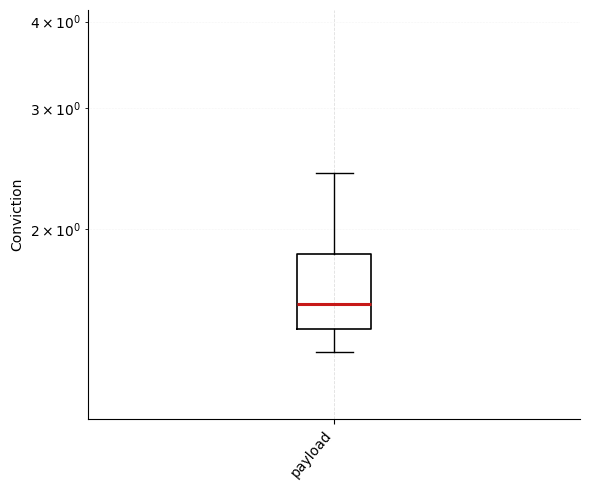

In [7]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

# ---------- 1) Locate columns (case-insensitive) ----------
def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

ENC_COL  = find_col(all_rules_crm, ["Encoding", "encoding", "Feature Encoding", "Feature_Encoding"])
LAB_COL  = find_col(all_rules_crm, ["Labeling", "labeling", "Label", "RHS_labeling"])
CONV_COL = find_col(all_rules_crm, ["Conviction", "conviction", "Conv", "conv"])
BEH_COL  = find_col(all_rules_crm, ["behavior", "Behavior"])

if any(x is None for x in [ENC_COL, LAB_COL, CONV_COL, BEH_COL]):
    raise ValueError(
        f"Missing required columns. Encoding={ENC_COL}, Labeling={LAB_COL}, Conviction={CONV_COL}, Behavior={BEH_COL}"
    )

# ---------- 2) Prepare data (allow inf) ----------
df = all_rules_crm[[LAB_COL, ENC_COL, CONV_COL, BEH_COL]].copy()

# keep only deviant behavior
df = df[df[BEH_COL].astype(str).str.strip().str.lower() == "deviant"]

# Normalize typical string infinities to np.inf BEFORE to_numeric
df[CONV_COL] = df[CONV_COL].replace(
    {"inf": np.inf, "Inf": np.inf, "INF": np.inf, "infinity": np.inf, "Infinity": np.inf}
)
df[CONV_COL] = pd.to_numeric(df[CONV_COL], errors="coerce")

# Conviction must be > 0 for log scale; drop non-positive / NaN
df = df[df[CONV_COL] > 0].dropna(subset=[CONV_COL])

# ---------- 3) Output folder & filename helper ----------
out_dir = Path("Figures")
out_dir.mkdir(parents=True, exist_ok=True)

def slugify(s: str) -> str:
    s = str(s).strip().lower().replace(" ", "_")
    return re.sub(r"[^a-z0-9_-]+", "", s)

# ---------- 4) Custom encoding order ----------
CUSTOM_ORDER = [
    "baseline", "payload", "seq_combined", "declare", "dwd",
    "bs_data", "bs_dwd", "seq_combined_data", "dec_data",
    "dec_dwd", "dec_dwd_data", "hybrid", "hybrid_data",
    "hybrid_dwd", "hybrid_dwd_data",
]
present_all = df[ENC_COL].unique().tolist()
extras = [e for e in present_all if e not in CUSTOM_ORDER]
enc_order = CUSTOM_ORDER + extras

# ---------- 5) Styling ----------
median_color = (199/255.0, 25/255.0, 24/255.0)

# ---------- 6) Plot per labeling and SAVE ----------
for labeling, dsub in df.groupby(LAB_COL):
    encs_present = [e for e in enc_order if e in dsub[ENC_COL].unique()]

    # Split per encoding into finite values and count of infinities
    data_finite = []
    inf_counts = []
    for e in encs_present:
        vals = dsub.loc[dsub[ENC_COL] == e, CONV_COL].values
        finite_vals = vals[np.isfinite(vals)]
        inf_count = np.sum(~np.isfinite(vals))  # count infinities
        data_finite.append(finite_vals)
        inf_counts.append(int(inf_count))

    # If all encodings are empty after filtering, skip
    if all(len(v) == 0 for v in data_finite):
        continue

    # Figure size compact for two-per-row
    fig_w, fig_h = max(6, 0.6 * len(encs_present)), 5
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    ax.boxplot(
        data_finite,
        labels=encs_present,
        showmeans=False,
        showfliers=False,
        medianprops={"color": median_color, "linewidth": 2.2},
        boxprops={"linewidth": 1.2},
        whiskerprops={"linewidth": 1.0},
        capprops={"linewidth": 1.0},
    )

    # Log scale with readable ticks
    ax.set_yscale("log")
    ax.yaxis.set_major_locator(LogLocator(base=10))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
    ax.yaxis.set_major_formatter(LogFormatterSciNotation())

    # Determine a sensible upper limit from finite data
    all_finite_vals = np.concatenate([v for v in data_finite if len(v) > 0])
    ymin = max(1e-3, np.nanmin(all_finite_vals) * 0.8)  # keep >0
    ymax = np.nanmax(all_finite_vals) * 1.5
    if not np.isfinite(ymax) or ymax <= 0:
        ymax = 10.0
    ax.set_ylim(ymin, ymax)

    # Clean look: subtle grid + despine
    ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.4)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.25)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    ax.set_ylabel("Conviction")
    plt.xticks(rotation=50, ha="right")

    # Annotate infinity counts above each box (if any)
    for i, (enc, inf_n) in enumerate(zip(encs_present, inf_counts), start=1):
        if inf_n > 0:
            ax.text(i, ymax * 1.05, f"∞ ({inf_n})", ha="center", va="bottom", fontsize=9)

    # Increase top margin for the annotations
    ax.set_ylim(ymin, ymax * 1.15)

    plt.tight_layout()

    # Save BEFORE show
    fname_base = f"boxplot_conviction_{slugify(labeling)}"
    fig.savefig(out_dir / f"{fname_base}.png", dpi=300, bbox_inches="tight")
    # Optional vector export:
    # fig.savefig(out_dir / f"{fname_base}.pdf", bbox_inches="tight")

    plt.show()
